In [1]:
#code based on: https://www.kaggle.com/hengzheng/news-category-classifier-val-acc-0-65

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6,6)

from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints

from keras.layers import Dense, Input, LSTM, Bidirectional, Activation, Conv1D, GRU, TimeDistributed
from keras.layers import Dropout, Embedding, GlobalMaxPooling1D, MaxPooling1D, Add, Flatten, SpatialDropout1D
from keras.layers import GlobalAveragePooling1D, BatchNormalization, concatenate
from keras.layers import Reshape, merge, Concatenate, Lambda, Average
from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint
from keras.initializers import Constant
from keras.layers.merge import add

from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


import os

Using TensorFlow backend.


In [2]:
df = pd.read_json('.../newsProc.result.json', encoding='utf8')
df.head()

,id,headline,textBody,source,sourceName,author,topic,link,crawlDate,creationDate
0,3110,George Soros lobte im Vorfeld der Wahl „Sardin...,"Der Vorsitzende der italienischen Lega, Matteo...",https://www.epochtimes.de/,epoch,Von Reinhard Werner,Deutschland Unternehmen Reise Deutschland Chin...,https://www.epochtimes.de/politik/europa/patt-...,1580127189000,27. Januar 2020
1,3069,Söder: Der Kurs des rechten Flügels ist die „V...,75 Jahre nach der Befreiung des Vernichtungsla...,https://www.epochtimes.de/,epoch,Epoch Times,Deutschland Unternehmen Reise Deutschland Chin...,https://www.epochtimes.de/politik/deutschland/...,1580123385000,27. Januar 2020
2,3070,Eine Buchempfehlung vom Verlag der Epoch Times,Polizei-Auto.Foto: iStock Die nordrhein-westfä...,https://www.epochtimes.de/,epoch,Epoch Times,Deutschland Unternehmen Reise Deutschland Chin...,https://www.epochtimes.de/politik/deutschland/...,1580123385000,27. Januar 2020
3,3071,Zahl der Solo-Selbstständigen rückläufig,In Deutschland hatten zuletzt rund 764.000 Erw...,https://www.epochtimes.de/,epoch,Epoch Times,Deutschland Unternehmen Reise Deutschland Chin...,https://www.epochtimes.de/politik/deutschland/...,1580123385000,27. Januar 2020
4,3072,Bitte um Privatsphäre,Superstar Kobe Bryant mit Tochter Gianna Maria...,https://www.epochtimes.de/,epoch,Epoch Times,Deutschland Unternehmen Reise Deutschland Chin...,https://www.epochtimes.de/sport/basketball/tod...,1580123385000,27. Januar 2020


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2568 entries, 0 to 2567
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            2568 non-null   int64 
 1   headline      2568 non-null   object
 2   textBody      2568 non-null   object
 3   source        2568 non-null   object
 4   sourceName    2568 non-null   object
 5   author        2568 non-null   object
 6   topic         2568 non-null   object
 7   link          2568 non-null   object
 8   crawlDate     2568 non-null   int64 
 9   creationDate  498 non-null    object
dtypes: int64(2), object(8)
memory usage: 200.8+ KB


In [4]:
cates = df.groupby('topic')
print("total categories:", cates.ngroups)
print(cates.size())

total categories: 140
topic
                                   62
Ausland                           208
Australian Open                    48
Auto & Verkehr                     18
Autoren                             6
                                 ... 
Wie erkläre ich’s meinem Kind?      2
Wintersport                        36
Wirtschaft                        110
Wissen                              8
Wohnen                              6
Length: 140, dtype: int64


In [5]:
df['topic']

0       Deutschland Unternehmen Reise Deutschland Chin...
1       Deutschland Unternehmen Reise Deutschland Chin...
2       Deutschland Unternehmen Reise Deutschland Chin...
3       Deutschland Unternehmen Reise Deutschland Chin...
4       Deutschland Unternehmen Reise Deutschland Chin...
                              ...                        
2563                                    Netzkonferenz DLD
2564                                 Weltwirtschaftsforum
2565                                 Weltwirtschaftsforum
2566                                              Ausland
2567                                               Medien
Name: topic, Length: 2568, dtype: object

The newspaper "epoch" has categories that aren't aussagekräftig. Even though this will compromise our findings we will eliminate those categories by replacing them with "none"

In [7]:
df = df[df['topic'].str.split().str.len().lt(10)]
df.head()

,id,headline,textBody,source,sourceName,author,topic,link,crawlDate,creationDate
7,3067,"Auschwitz und Flossenbürg: 1,2 Millionen Mensc...",,https://www.epochtimes.de/,epoch,,,https://www.epochtimes.de/wissen/forschung,1580123384000,
176,1584,Senat beginnt Debatte in Impeachment-Prozess g...,,https://www.epochtimes.de/,epoch,,,https://www.epochtimes.de/politik/welt,1579648180000,
209,1384,Italien: Senats-Ausschuss stimmt für Aufhebung...,,https://www.epochtimes.de/,epoch,,,https://www.epochtimes.de/politik/europa,1579604990000,
220,1292,„Ein Schlag ins Gesicht der Imker“: Behauptung...,,https://www.epochtimes.de/,epoch,,,https://www.epochtimes.de/politik/deutschland,1579599115000,
221,1293,Solar-Lobbyist will Klima-Skeptiker durch Haft...,,https://www.epochtimes.de/,epoch,,,https://www.epochtimes.de/umwelt/klima,1579599115000,


In [9]:
t = df.topic.str.split(expand=True).stack()
shorttopic = t.loc[t.str.len() <= 10].groupby(level=0).apply(' '.join)

Here we fill them with value "none" so that each headline can be still assigned to a category.

In [11]:
df.fillna('none')

,id,headline,textBody,source,sourceName,author,topic,link,crawlDate,creationDate
7,3067,"Auschwitz und Flossenbürg: 1,2 Millionen Mensc...",,https://www.epochtimes.de/,epoch,,,https://www.epochtimes.de/wissen/forschung,1580123384000,
176,1584,Senat beginnt Debatte in Impeachment-Prozess g...,,https://www.epochtimes.de/,epoch,,,https://www.epochtimes.de/politik/welt,1579648180000,
209,1384,Italien: Senats-Ausschuss stimmt für Aufhebung...,,https://www.epochtimes.de/,epoch,,,https://www.epochtimes.de/politik/europa,1579604990000,
220,1292,„Ein Schlag ins Gesicht der Imker“: Behauptung...,,https://www.epochtimes.de/,epoch,,,https://www.epochtimes.de/politik/deutschland,1579599115000,
221,1293,Solar-Lobbyist will Klima-Skeptiker durch Haft...,,https://www.epochtimes.de/,epoch,,,https://www.epochtimes.de/umwelt/klima,1579599115000,
...,...,...,...,...,...,...,...,...,...,...
2563,1204,Die neuen Entdecker,"Wir waren von einem Nebel umhüllt, der uns nur...",https://www.faz.net/aktuell/,faz,Alexander Armbruster,Netzkonferenz DLD,https://www.faz.net/aktuell/wirtschaft/netzkon...,1579598618000,none
2564,1196,Sinnsuche in einer Welt der Unrast,Unter den rund 2000 Gästen des Weltwirtschafts...,https://www.faz.net/aktuell/,faz,Gerald Braunberger Davos,Weltwirtschaftsforum,https://www.faz.net/aktuell/wirtschaft/weltwir...,1579598617000,none
2565,1197,Deutsche zweifeln am Kapitalismus,"Viele Menschen in Deutschland glauben nicht, d...",https://www.faz.net/aktuell/,faz,Sven Astheimer Davos,Weltwirtschaftsforum,https://www.faz.net/aktuell/wirtschaft/weltwir...,1579598617000,none
2566,1198,Iran bestätigt Abschuss mit zwei Raketen,Das irrtümlich in Iran abgeschossene ukrainisc...,https://www.faz.net/aktuell/,faz,,Ausland,https://www.faz.net/aktuell/politik/ausland/fl...,1579598617000,none


In [13]:
cates = df.groupby('topic')
print("total categories:", cates.ngroups)
print(cates.size())

total categories: 110
topic
                                   62
Ausland                           208
Australian Open                    48
Auto & Verkehr                     18
Autoren                             6
                                 ... 
Wie erkläre ich’s meinem Kind?      2
Wintersport                        36
Wirtschaft                        110
Wissen                              8
Wohnen                              6
Length: 110, dtype: int64


The amount of categories is still too large for a comprehensive analysis. Many categories have less than 10 entries. We are going to delete them.

In [21]:
v = df[['topic']]
df[v.replace(v.stack().value_counts()).gt(10).all(1)]

,id,headline,textBody,source,sourceName,author,topic,link,crawlDate,creationDate
7,3067,"Auschwitz und Flossenbürg: 1,2 Millionen Mensc...",,https://www.epochtimes.de/,epoch,,,https://www.epochtimes.de/wissen/forschung,1580123384000,
176,1584,Senat beginnt Debatte in Impeachment-Prozess g...,,https://www.epochtimes.de/,epoch,,,https://www.epochtimes.de/politik/welt,1579648180000,
209,1384,Italien: Senats-Ausschuss stimmt für Aufhebung...,,https://www.epochtimes.de/,epoch,,,https://www.epochtimes.de/politik/europa,1579604990000,
220,1292,„Ein Schlag ins Gesicht der Imker“: Behauptung...,,https://www.epochtimes.de/,epoch,,,https://www.epochtimes.de/politik/deutschland,1579599115000,
221,1293,Solar-Lobbyist will Klima-Skeptiker durch Haft...,,https://www.epochtimes.de/,epoch,,,https://www.epochtimes.de/umwelt/klima,1579599115000,
...,...,...,...,...,...,...,...,...,...,...
2562,1203,Wo die schlimmen Kerle wohnen,"Es gibt in Deutschland nahezu niemanden mehr, ...",https://www.faz.net/aktuell/,faz,Elena Witzeck,Debatten,https://www.faz.net/aktuell/feuilleton/debatte...,1579598618000,None
2564,1196,Sinnsuche in einer Welt der Unrast,Unter den rund 2000 Gästen des Weltwirtschafts...,https://www.faz.net/aktuell/,faz,Gerald Braunberger Davos,Weltwirtschaftsforum,https://www.faz.net/aktuell/wirtschaft/weltwir...,1579598617000,None
2565,1197,Deutsche zweifeln am Kapitalismus,"Viele Menschen in Deutschland glauben nicht, d...",https://www.faz.net/aktuell/,faz,Sven Astheimer Davos,Weltwirtschaftsforum,https://www.faz.net/aktuell/wirtschaft/weltwir...,1579598617000,None
2566,1198,Iran bestätigt Abschuss mit zwei Raketen,Das irrtümlich in Iran abgeschossene ukrainisc...,https://www.faz.net/aktuell/,faz,,Ausland,https://www.faz.net/aktuell/politik/ausland/fl...,1579598617000,None


In [27]:
v

,topic
7,
176,
209,
220,
221,
...,...
2563,Netzkonferenz DLD
2564,Weltwirtschaftsforum
2565,Weltwirtschaftsforum
2566,Ausland


We apply a tokenizer to the headline text and delete words with a legth less than 5; this way of text cleaning isn't language specific, but also not very precise

In [34]:
#using headline and short description

df['text'] = df.headline

#tokenizing

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.text)
X = tokenizer.texts_to_sequences(df.text)
df['words'] = X

#delete empty and short data

df['word_length'] = df.words.apply(lambda i: len(i))
df = df[df.word_length >= 5]

df.head()

,id,headline,textBody,source,sourceName,author,topic,link,crawlDate,creationDate,text,words,word_length
7,3067,"Auschwitz und Flossenbürg: 1,2 Millionen Mensc...",,https://www.epochtimes.de/,epoch,,,https://www.epochtimes.de/wissen/forschung,1580123384000,,"Auschwitz und Flossenbürg: 1,2 Millionen Mensc...","[77, 5, 759, 213, 760, 89, 78, 351, 13, 761, 102]",11
176,1584,Senat beginnt Debatte in Impeachment-Prozess g...,,https://www.epochtimes.de/,epoch,,,https://www.epochtimes.de/politik/welt,1579648180000,,Senat beginnt Debatte in Impeachment-Prozess g...,"[762, 352, 763, 3, 160, 161, 20, 44]",8
209,1384,Italien: Senats-Ausschuss stimmt für Aufhebung...,,https://www.epochtimes.de/,epoch,,,https://www.epochtimes.de/politik/europa,1579604990000,,Italien: Senats-Ausschuss stimmt für Aufhebung...,"[214, 764, 765, 766, 4, 767, 11, 353, 768, 45,...",14
220,1292,„Ein Schlag ins Gesicht der Imker“: Behauptung...,,https://www.epochtimes.de/,epoch,,,https://www.epochtimes.de/politik/deutschland,1579599115000,,„Ein Schlag ins Gesicht der Imker“: Behauptung...,"[354, 771, 125, 355, 1, 772, 773, 19, 774, 46,...",16
221,1293,Solar-Lobbyist will Klima-Skeptiker durch Haft...,,https://www.epochtimes.de/,epoch,,,https://www.epochtimes.de/umwelt/klima,1579599115000,,Solar-Lobbyist will Klima-Skeptiker durch Haft...,"[779, 780, 40, 162, 781, 126, 782, 48, 356, 357]",10


In [35]:
df.word_length.describe()

count    1392.000000
mean        6.459770
std         1.475841
min         5.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        16.000000
Name: word_length, dtype: float64

We are padding the "words" in order for all or words to be fed easily to our mtric, padding just adds 0s to our tokenized words.

In [36]:
# using 50 for padding length

maxlen = 50
X = list(sequence.pad_sequences(df.words, maxlen=maxlen))

In [39]:
# category to id

categories = df.groupby('topic').size().index.tolist()
category_int = {}
int_category = {}
for i, k in enumerate(categories):
    category_int.update({k:i})
    int_category.update({i:k})

df['c2id'] = df['topic'].apply(lambda x: category_int[x])

c:\users\slavina\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [42]:
word_index = tokenizer.word_index

EMBEDDING_DIM = 50

embeddings_index = {}
f = open ('c:/Users/slavina/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close

print('Found %s unique tokens.' % len(word_index))
print('Total %s word vectors.' % len(embeddings_index))

Found 2568 unique tokens.
Total 400000 word vectors.


In [43]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index)+1,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=maxlen,
                            trainable=False)

In [44]:
# prepared data 

X = np.array(X)
Y = np_utils.to_categorical(list(df.c2id))

# and split to training set and validation set

seed = 29
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=seed)

In [45]:
inp = Input(shape=(maxlen,), dtype='int32')
embedding = embedding_layer(inp)
stacks = []
for kernel_size in [2, 3, 4]:
    conv = Conv1D(64, kernel_size, padding='same', activation='relu', strides=1)(embedding)
    pool = MaxPooling1D(pool_size=3)(conv)
    drop = Dropout(0.5)(pool)
    stacks.append(drop)

merged = Concatenate()(stacks)
flatten = Flatten()(merged)
drop = Dropout(0.5)(flatten)
outp = Dense(len(int_category), activation='softmax')(drop)

TextCNN = Model(inputs=inp, outputs=outp)
TextCNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

TextCNN.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 50)       128450      input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 50, 64)       6464        embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 50, 64)       9664        embedding_1[0][0]                
____________________________________________________________________________________________

In [46]:
textcnn_history = TextCNN.fit(x_train, 
                              y_train, 
                              batch_size=128, 
                              epochs=20, 
                              validation_data=(x_val, y_val))

Train on 1113 samples, validate on 279 samples
Epoch 1/20
1113/1113 [==============================] - 1s 1ms/step - loss: 4.3835 - accuracy: 0.0458 - val_loss: 3.9728 - val_accuracy: 0.0896
Epoch 2/20
1113/1113 [==============================] - 0s 341us/step - loss: 3.9625 - accuracy: 0.0719 - val_loss: 3.7835 - val_accuracy: 0.0896
Epoch 3/20
1113/1113 [==============================] - 1s 485us/step - loss: 3.7688 - accuracy: 0.1033 - val_loss: 3.6832 - val_accuracy: 0.1111
Epoch 4/20
1113/1113 [==============================] - 0s 409us/step - loss: 3.6154 - accuracy: 0.1330 - val_loss: 3.5946 - val_accuracy: 0.1254
Epoch 5/20
1113/1113 [==============================] - 0s 377us/step - loss: 3.4941 - accuracy: 0.1491 - val_loss: 3.5266 - val_accuracy: 0.1254
Epoch 6/20
1113/1113 [==============================] - ETA: 0s - loss: 3.3904 - accuracy: 0.17 - 0s 346us/step - loss: 3.3810 - accuracy: 0.1797 - val_loss: 3.4623 - val_accuracy: 0.1290
Epoch 7/20
1113/1113 [===============

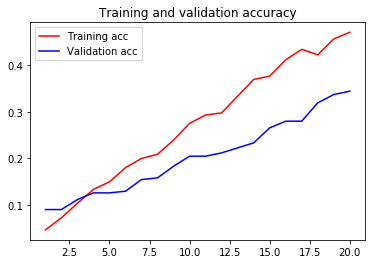

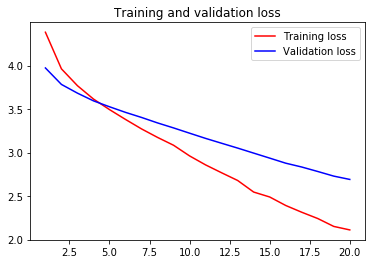

In [49]:
acc = textcnn_history.history['accuracy']
val_acc = textcnn_history.history['val_accuracy']
loss = textcnn_history.history['loss']
val_loss = textcnn_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()

plt.show()

In [51]:
# Bidrectional LSTM with convolution
# from https://www.kaggle.com/eashish/bidirectional-gru-with-convolution

inp = Input(shape=(maxlen,), dtype='int32')
x = embedding_layer(inp)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(128, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = Conv1D(64, kernel_size=3)(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool])
outp = Dense(len(int_category), activation="softmax")(x)

BiGRU = Model(inp, outp)
BiGRU.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

BiGRU.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 50)       128450      input_3[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 50, 50)       0           embedding_1[2][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 50, 256)      137472      spatial_dropout1d_1[0][0]        
____________________________________________________________________________________________

In [52]:
# training

bigru_history = BiGRU.fit(x_train, 
                          y_train, 
                          batch_size=128, 
                          epochs=20, 
                          validation_data=(x_val, y_val))

Train on 1113 samples, validate on 279 samples
Epoch 1/20
1113/1113 [==============================] - 4s 3ms/step - loss: 4.4661 - acc: 0.0359 - val_loss: 4.3039 - val_acc: 0.0860
Epoch 2/20
1113/1113 [==============================] - 2s 2ms/step - loss: 4.1203 - acc: 0.1051 - val_loss: 4.0225 - val_acc: 0.0896
Epoch 3/20
1113/1113 [==============================] - 2s 2ms/step - loss: 3.8983 - acc: 0.1123 - val_loss: 3.8133 - val_acc: 0.0860
Epoch 4/20
1113/1113 [==============================] - 2s 2ms/step - loss: 3.7282 - acc: 0.1357 - val_loss: 3.7061 - val_acc: 0.1075
Epoch 5/20
1113/1113 [==============================] - 2s 2ms/step - loss: 3.6128 - acc: 0.1671 - val_loss: 3.6273 - val_acc: 0.1039
Epoch 6/20
1113/1113 [==============================] - 2s 2ms/step - loss: 3.4974 - acc: 0.1779 - val_loss: 3.5560 - val_acc: 0.1111
Epoch 7/20
1113/1113 [==============================] - 2s 2ms/step - loss: 3.3867 - acc: 0.2201 - val_loss: 3.4872 - val_acc: 0.1505
Epoch 8/20
1113

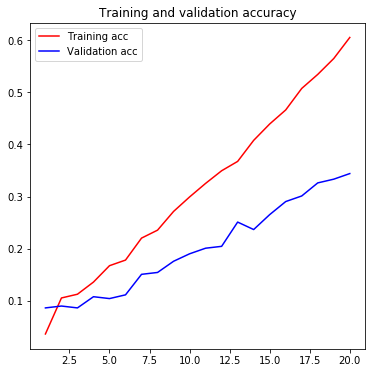

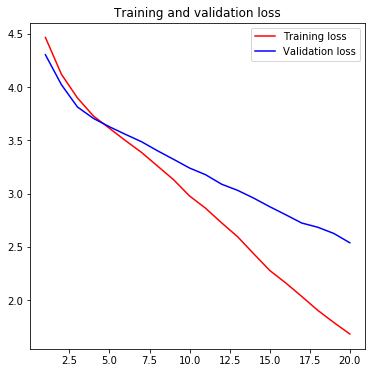

In [53]:
plt.rcParams['figure.figsize'] = (6,6)

acc = bigru_history.history['acc']
val_acc = bigru_history.history['val_acc']
loss = bigru_history.history['loss']
val_loss = bigru_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()

plt.show()

In [57]:
# confusion matrix

predicted = TextCNN.predict(x_val)
cm = pd.DataFrame(confusion_matrix(y_val.argmax(axis=1), predicted.argmax(axis=1)))

In [58]:
from IPython.display import display
pd.options.display.max_columns = None
display(cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54
0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,17,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0
3,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
6,0,2,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0
7,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
9,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0


In [59]:


def evaluate_accuracy(model):
    predicted = model.predict(x_val)
    diff = y_val.argmax(axis=-1) - predicted.argmax(axis=-1)
    corrects = np.where(diff == 0)[0].shape[0]
    total = y_val.shape[0]
    return float(corrects/total)



In [60]:
print("model TextCNN accuracy:          %.6f" % evaluate_accuracy(TextCNN))
print("model Bidirectional GRU + Conv:  %.6f" % evaluate_accuracy(BiGRU))

model TextCNN accuracy:          0.344086
model Bidirectional GRU + Conv:  0.344086


In [61]:
def evaluate_accuracy_ensemble(models):
    res = np.zeros(shape=y_val.shape)
    for model in models:
        predicted = model.predict(x_val)
        res += predicted
    res /= len(models)
    diff = y_val.argmax(axis=-1) - res.argmax(axis=-1)
    corrects = np.where(diff == 0)[0].shape[0]
    total = y_val.shape[0]
    return float(corrects/total)

In [62]:
print(evaluate_accuracy_ensemble([TextCNN, BiGRU]))

0.3942652329749104


In [85]:
import shap
# load JS visualization code to notebook
import tensorflow.keras.backend 
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]
# we use the first 100 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(TextCNN,  background)

ValueError: Layer model_1 was called with an input that isn't a symbolic tensor. Received type: <class 'numpy.ndarray'>. Full input: [array([[   0,    0,    0, ...,   22,    1, 1969],
       [   0,    0,    0, ...,    5, 1439, 1440],
       [   0,    0,    0, ...,   56,   17,  152],
       ...,
       [   0,    0,    0, ...,  613,   21,  614],
       [   0,    0,    0, ...,  310, 1711, 1712],
       [   0,    0,    0, ..., 1726,   11,  581]])]. All inputs to the layer should be tensors.